In [ ]:
import jax
import jax.numpy as jnp
import jax.scipy.special
import dataclasses
from functools import partial

import subprocess
import os
import h5py

import vtk
from vtk.util import numpy_support

import jaxdem as jd

import pydpmd as dp
from pydpmd.utils import split_systems

jax.config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np

In [ ]:
def build_state_from_data(data, dt):
    mats = [jd.Material.create("elastic", young=data.e_interaction[0], poisson=0.5, density=1.0)]
    matcher = jd.MaterialMatchmaker.create("harmonic")
    mat_table = jd.MaterialTable.from_materials(mats, matcher=matcher)
    state = jd.State.create(pos=data.pos, rad=data.rad, mass=data.mass, volume=data.area)
    system = jd.System.create(
        state_shape=state.shape,
        dt=dt,
        linear_integrator_type="verlet",
        domain_type="periodic",
        force_model_type="spring",
        collider_type="naive",
        mat_table=mat_table,
        domain_kw=dict(
            box_size=data.box_size[0],
        ),
    )
    return system, state

In [46]:
# path = '/home/mmccraw/dev/data/11-15-25/jamming/rb/mu-1.0-nv-31/jamming_9'
# path = '/home/mmccraw/dev/data/11-06-25/jamming/N-100/31-1.00/jamming_2'
path = '/home/mmccraw/dev/data/11-15-25/jamming/disk/jamming_9'
data = dp.data.load(path, location=['final'])

count = 0

dt = 1e-2
states, systems = [], []
for d in split_systems(data):
    system, state = build_state_from_data(d, dt)
    systems.append(system)
    states.append(state)
    
    count += 1
    if count > 1:
        break

state = jd.State.stack(states)
system = jd.System.stack(systems)

In [ ]:
n_steps = 100000

state, system = system.step(state, system, n=n_steps)


save_stride = 10
n_snapshots = n_steps // save_stride

final_state, final_system, (traj_state, traj_system) = jd.System.trajectory_rollout(
    state, system, n=n_snapshots, stride=save_stride
)

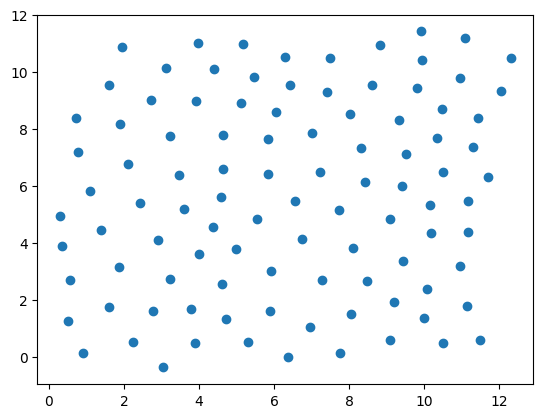

In [51]:
plt.scatter(*state.pos[0].T)